# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM(object):
  def __init__(self, n_components=1, tol=1e-3, max_iter=100):
    self.n_components = n_components
    self.tol = tol
    self.max_iter = max_iter
    self.weights, self.means, self.covars = None, None, None

  def initialize_params(self, X):
    num_samples, num_features = X.shape
    self.weights = np.full(self.n_components, fill_value=1/self.n_components)
    random_indices = np.random.permutation(num_samples)[:self.n_components]
    self.means = X[random_indices]
    self.covars = np.array([np.eye(num_features) for _ in range(self.n_components)])

  def E_step(self, X):
    responsibility_matrix = np.zeros((X.shape[0], self.n_components))
    for idx in range(self.n_components):
        pdf = multivariate_normal.pdf(X, mean=self.means[idx], cov=self.covars[idx])
        responsibility_matrix[:, idx] = self.weights[idx] * pdf
    sum_of_responsibilities = responsibility_matrix.sum(axis=1).reshape(-1, 1)
    responsibility_matrix /= sum_of_responsibilities
    return responsibility_matrix

  def M_step(self, X, responsibilities):
    Nk = responsibilities.sum(axis=0)
    self.weights = Nk / Nk.sum()
    self.means = (X.T @ responsibilities / Nk).T
    for i in range(self.n_components):
        X_centered = X - self.means[i]
        self.covars[i] = np.dot(X_centered.T, responsibilities[:, i][:, np.newaxis] * X_centered) / Nk[i]
        self.covars[i] += np.eye(X_centered.shape[1]) * 1e-6

  def fit(self, X):
    self.initialize_params(X)
    previous_log_likelihood = -np.inf
    for iteration in range(self.max_iter):
        responsibilities = self.E_step(X)
        self.M_step(X, responsibilities)
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        if np.abs(log_likelihood - previous_log_likelihood) <= self.tol:
            break
        previous_log_likelihood = log_likelihood

  def predict(self, X):
    responsibilities = self.E_step(X)
    return np.argmax(responsibilities, axis=1)

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
source_folder = '/content/drive/MyDrive/rollnumber_A2_Q2/videos'
video = 'traffic.gif'

source_path = f'{source_folder}/{video}'

In [21]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [15]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [22]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [23]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

In [24]:
frames.shape

(80, 120, 160, 3)

#### Splitting the data

In [25]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

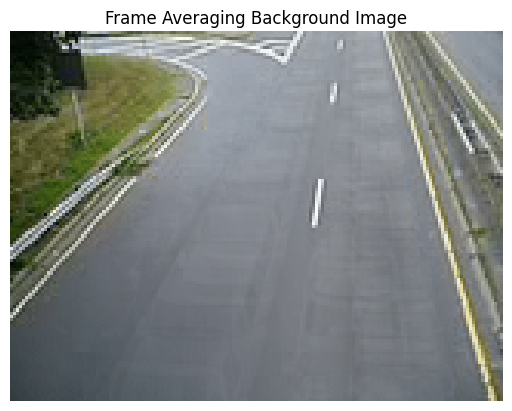

In [26]:
import matplotlib.pyplot as plt

def compute_frame_average(train_frames):
    return np.mean(train_frames, axis=0)
average_background = compute_frame_average(train_frames)

plt.imshow(average_background)
plt.title('Frame Averaging Background Image')
plt.axis('off')
plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [28]:
import numpy as np

def fit_gmm_to_each_pixel(frames, num_components=2, iterations=10):
    frames_count, height, width, depth = frames.shape
    per_pixel_gmms = np.empty((height, width), dtype=object)

    rearranged_frames = frames.transpose(1, 2, 0, 3).reshape(height * width, frames_count, depth)

    for row in range(height):
        for col in range(width):
            pixel_idx = row * width + col
            pixel_series = rearranged_frames[pixel_idx].reshape(-1, depth)
            pixel_gmm = GMM(n_components=num_components, tol=1e-3, max_iter=iterations)
            pixel_gmm.fit(pixel_series)
            per_pixel_gmms[row, col] = pixel_gmm

    return per_pixel_gmms

pixel_gmms = fit_gmm_to_each_pixel(train_frames)

#### Extract Background Image from the trained model

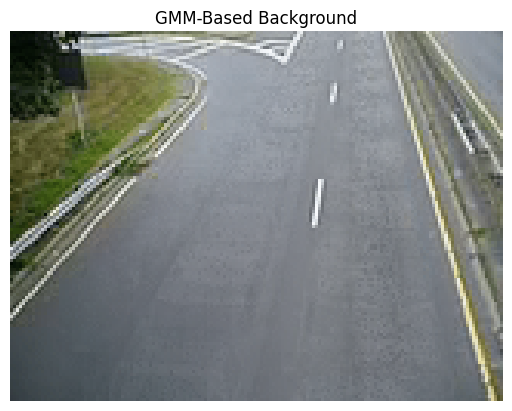

In [30]:
import numpy as np

def obtain_background_via_gmms(gmms_per_pixel):
    img_height, img_width = gmms_per_pixel.shape
    extracted_background = np.zeros((img_height, img_width, 3), dtype=float)

    for row in range(img_height):
        for col in range(img_width):
            current_gmm = gmms_per_pixel[row, col]
            dominant_component_index = np.argmax(current_gmm.weights)
            extracted_background[row, col] = current_gmm.means[dominant_component_index]

    return extracted_background

background_img_gmm = obtain_background_via_gmms(pixel_gmms)

plt.imshow(background_img_gmm)
plt.title('GMM-Based Background')
plt.axis('off')
plt.show()


### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [33]:
# helper functions
from google.colab.patches import cv2_imshow

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

#### Frame Averaging

In [34]:
import numpy as np
foreground_frames = np.abs(test_frames - average_background)

display_frames(foreground_frames)
save_frames(foreground_frames, 10.0, '/content/drive/MyDrive/rollnumber_A2_Q2/results', 'frameaveraging')

Output hidden; open in https://colab.research.google.com to view.

#### GMMs per pixel

In [36]:
import numpy as np
foreground_frames_gmm = np.abs(test_frames - background_img_gmm)

display_frames(foreground_frames_gmm)
save_frames(foreground_frames_gmm, 10.0, '/content/drive/MyDrive/rollnumber_A2_Q2/results', 'gmm')

Output hidden; open in https://colab.research.google.com to view.